In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# What is the probability a coin is biased?
What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?

### 1) Define hypotheses
Discrete set of hypotheses for the latent probability of a heads for the coin:

In [3]:
n_hypos = 1001
p_heads = np.linspace(0, 1, n_hypos)

### 2) Assign prior probabilities to hypotheses

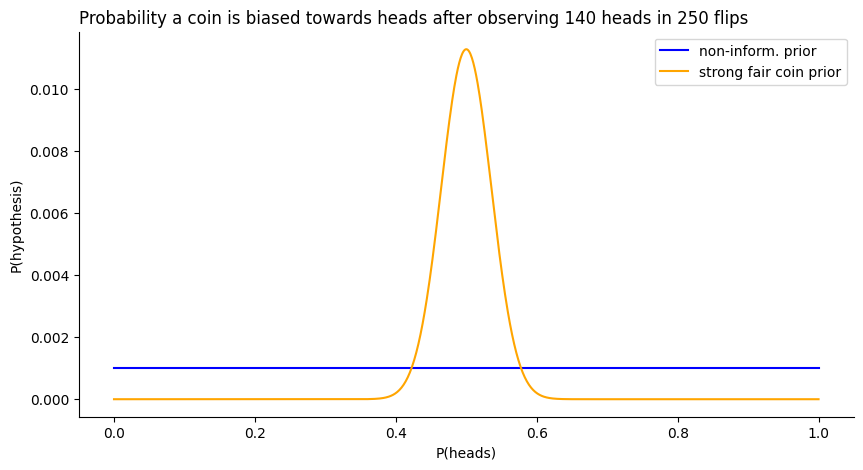

In [6]:
# Prior distribution for probability of heads
# Non-informative prior
noninform_prior = np.ones(n_hypos)
noninform_prior /= noninform_prior.sum()

# Using a fairly strong prior that the coin is unbiased
strong_prior = stats.beta(a=100, b=100).pdf(p_heads)
strong_prior /= strong_prior.sum()


_, ax = plt.subplots(figsize=(10,5))
ax.plot(p_heads, noninform_prior, label="non-inform. prior", color="blue")
ax.plot(p_heads, strong_prior, label="strong fair coin prior", color="orange")

ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Probability a coin is biased towards heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()

### 3) Calculate likelihoods for hypotheses
Use the binominal likelihood function to calculate the likelihood of seeing 140 heads in 250 flips for each hypothesis of the coin's latent chance of landing on heads any time it's flipped.

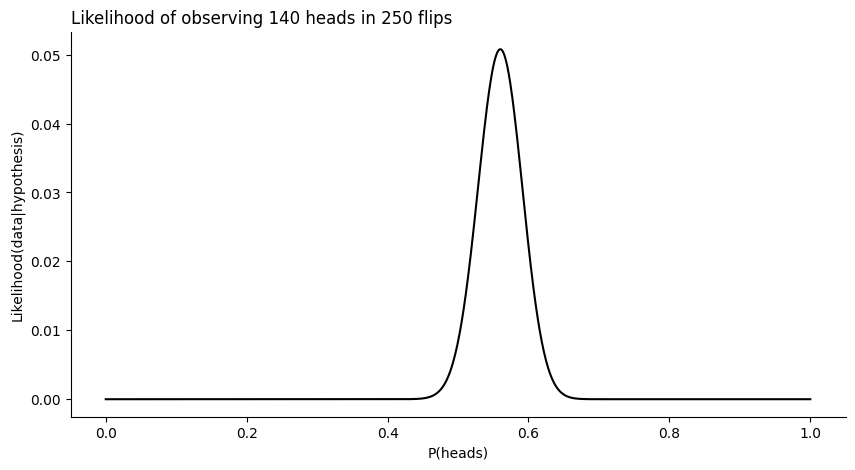

In [10]:
# Binomial likelihoods
likelihood = stats.binom.pmf(k=140, n=250, p=p_heads)

_, ax = plt.subplots(figsize=(10,5))
ax.plot(p_heads, likelihood, color="black")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Likelihood of observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
_ = ax.set_ylabel("Likelihood(data|hypothesis)")

### 4) Calculate posterior probabilities for hypotheses for both priors
Combine each prior distribution with the same likelihood to get posterior distributions. Then find the area under each posterior distribution that is > 52.5% (what we deemed to be materially biased).

Proability that the coin is materially biased given the data: P(p_heads > 52.5% | data)
Non-informative prior    : 86.16%
Strong prior coin is fair: 63.11%


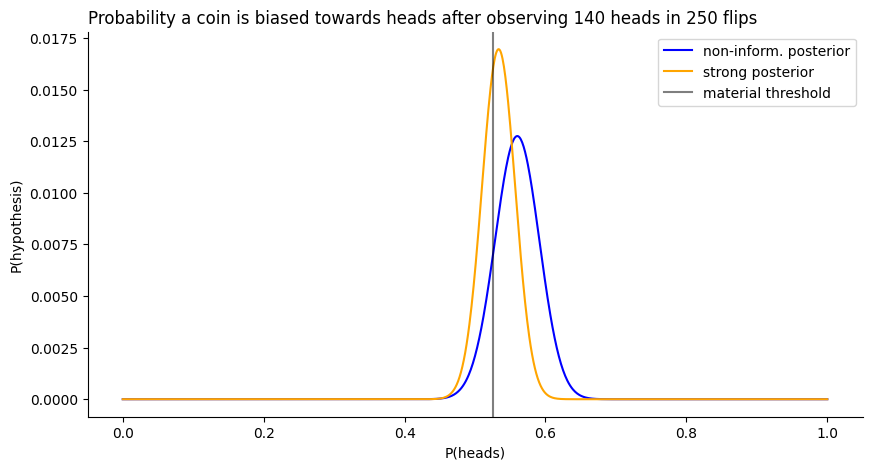

In [17]:
# Posteriors
noninform_posterior = noninform_prior * likelihood
noninform_posterior /= noninform_posterior.sum()

strong_posterior = strong_prior * likelihood
strong_posterior /= strong_posterior.sum()

df = pd.DataFrame(
    dict(
        noninform_prior=noninform_prior,
        strong_prior=strong_prior,
        likelihood=likelihood,
        noninform_posterior=noninform_posterior,
        strong_posterior=strong_posterior,
    ),
    index=pd.Series(p_heads, name="P(heads)")
)

_, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df.noninform_posterior, label="non-inform. posterior", color="blue")
ax.plot(df.index, df.strong_posterior, label="strong posterior", color="orange")
ax.axvline(x=0.525, color="black", alpha=0.5, label="material threshold")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Probability a coin is biased towards heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()


print("Proability that the coin is materially biased given the data: P(p_heads > 52.5% | data)")
print(f"Non-informative prior    : {df.noninform_posterior[df.index > 0.525].sum():.2%}")
print(f"Strong prior coin is fair: {df.strong_posterior[df.index > 0.525].sum():.2%}")

# Dealing with social desirability bias
Social desirability bias is the tendency for people to change their answer to a question so it's more congruent with social norms. For example, asking people directly if they water their lawns on days the city has requested people refrain from watering to conserve resources will likely illicit untruthful answers from some. People will adjust their answer to show themselves in a more favorable light. This makes it challenging to estimate the true proportion of people who are watering their lawn on days the city has asked them not to. However, if you ask people indirectly whether they are cheating on their lawn watering, you can more accurately estimate this proportion.

For example, ask each surveyed person to flip a (fair) coin so only they can see whether it comes up heads or tails.
- If the coin comes up heads, they write down `YES` as their response to whether they water on non-watering days (irrespective of whether they do or not).
- If they get a tails, they answer truthfully

The introduction of the coin's random outcome and the fact that only the respondent knows if it came up heads or tails, will probably make people answer more truthfully; because, a `YES` response may be from either the coin landing on heads, or because they do cheat on their lawn watering.

Now, suppose you survey 30 people and 21 responded `YES` and 9 `NO` to the question of whether they water on day's the city has asked them no to. What is the posterior distribution for the proportion of people who cheat on their lawn watering?

## Priors for the proportion of lawn watering cheaters

In [ ]:
# Discrete set of hypotheses for the latent proportion of people who cheat on lawn watering
n_hypos = 1001
p_cheat = np.linspace(0, 1, n_hypos + 2)[1:-1]

# Prior distributions
# Non-informative prior
noninform_prior = stats.beta(a=1, b=1).pdf(p_cheat)

# prior that people are mostly honest (10% cheaters)
only_a_few_cheat_prior = stats.beta(a=1, b=9).pdf(p_cheat)

# prior that 70% people cheat
majority_cheat_prior = stats.beta(a=7, b=3).pdf(p_cheat)

prior = np.stack((noninform_prior, only_a_few_cheat_prior, majority_cheat_prior), axis=-1)

In [ ]:
%matplotlib ipympl

fig,ax = plt.subplots(figsize=(7,5))
ax.plot(p_cheat, noninform_prior, label="non-inform.")
ax.plot(p_cheat, only_a_few_cheat_prior, label="only a few cheat")
ax.plot(p_cheat, majority_cheat_prior, label="majority cheat")
ax.set_title(
    "Prior beliefs of % of lawn watering cheaters",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("Proportion of lawn watering cheaters")
ax.legend()

## Likelihood of the data

### Modeling the randomizing coin
- Given a fair coin, we'd expect 15 people to flip a heads and 15 to flip a tails, on average.
    - `stats.binom.mean(n=30, p=0.5)`
- Therefore our initial guess (using just the data) is 15 people flipped a tails and 6 responded `YES`.
- This gives us an estimate that ~40% of people cheat on their lawn watering. 
- However, we really need the distribution of possible outcomes of 30 people flipping the coin:
    - Probability # heads <= 15 in 30 trials: `stats.binom.cdf(k=15, n=30, p=0.5)` = 57.2%
- We need to take that uncertainty into account when estimating the proportion of people who flipped a tails and then answered `YES`. 
- Specifically, we need the likelihood of flipping 0 through 21 heads over 30 trials given a fair coin.

In [ ]:
p_heads = 0.5
n_trials = 30

n_heads = np.arange(0, 21 + 1)
head_likelihood = stats.binom.pmf(k=n_heads, n=n_trials, p=p_heads)

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
ax.bar(x=n_heads, height=head_likelihood)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Likelihood of flipping `k` heads in 30 trials, given a fair coin",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("# Heads")
ax.set_ylabel("Likelihood")

### Likelihoods across coin outcomes
Rather than modeling the likelihood of a single observed number of `YES` responses given each hypothesis of the proportion of lawn watering cheaters, we need to account for the 22 different mixes of heads and tails that might have occurred due to the impact of the randomizing coin, because we don't get to see the outcome of each coin toss.

In [ ]:
n_yes = 21 - n_heads
n_tail_trails = n_trials - n_heads

likelihood = stats.binom.pmf(
    k=n_yes[..., None],
    n=n_tail_trails[..., None],
    p=p_cheat[None,...]
)

### Combined likelihood
Now we can combine the likelihood of each of the 22 mixes of heads and tails we got from the randomizing coin with the likelihoods of each each hypothesis. The likelihood of each head/tail mix weights the likelihoods of the proportion hypothesis. Then, we can marginalize out the actual head/tail outcomes by summing up the weighted hypotheses.

In [ ]:
# Weighted average head/tail mixes
n_heads_wts = head_likelihood /  head_likelihood.sum()
combined_likelhood = n_heads_wts[..., None] * likelihood
combined_likelhood = combined_likelhood.sum(axis=0)

## Posteriors

Means:
- Uniformed prior: 38.2%
- Only a few_cheat prior: 16.9%
- Majority cheat prior: 54.0%

In [ ]:
# Combine likelihood with prior
posterior = prior * combined_likelhood[..., None]

# Normalize
posterior /= posterior.sum(axis=0, keepdims=True)

# Mean posterior estimate of proportion of lawn watering cheaters
posterior_mean = (p_cheat[:, None] * posterior).sum(0)
posterior_mean

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(p_cheat, posterior[:,0], label="non-inform.")
ax.plot(p_cheat, posterior[:,1], label="only a few cheat")
ax.plot(p_cheat, posterior[:,2], label="majority cheat")
ax.legend()

# Dealing with measurement errors
Now imagine we have a drone outfitted with an infrared camera, and a classification algorithm that's been trained to predict whether a lawn has been watered based on an IR image of a lawn. We can use images from the drone taken on a non-watering day to estimate the proportion of people who are watering with out regard to the restriction.

Using drone imagery, the model has reasonable accuracy but it's by no means perfect. It miss-classifies lawns as having been watered when they haven't about 25% of the time, and it predicts that a lawn wasn't watered when it actually has been about 5% of the time. Specifically, our posterior estimate on out-of-sample data for the model's prediction quality is:
- $P(watered | predicted\,watered) \sim beta(95,5)$
- $P(watered | predicted\,NOT\,watered) \sim beta(25,75)$

Using this drone and classification model, we image 80 randomly chosen lawns on a non-watering day and the model predicts 25 of them were watered. What's our posterior distribution for the actual proportion of lawns that were given this sample and our estimate's for the model's prediction errors?

## Priors for the proportion of lawn watering cheaters
Use the posteriors from our survey for our priors

In [ ]:
# Discrete set of hypotheses for the latent proportion of people who cheat on lawn watering
n_hypos = len(prior)
p_cheat = np.linspace(0, 1, n_hypos + 2)[1:-1]
prior = posterior.copy()

## Monte Carlo sampling to model prediction errors
We don't have a perfect measurement of the true number of lawns that were watered out of the 80 lawns we sampled (because our classification model makes mistakes). Therefore, we cannot use the watered/not watered predictions directly in our likelihood estimation. 

Instead, we can simulate a bunch of alternate universes, and in each simulated sample pretend we have the true count of watered and not watered lawns. The simulated counts are drawn from the distributions of our model's classification accuracy. Then we can use those simulated samples in our likelihood calculation of our hypotheses for the proportion of people who cheat on their lawn watering. Finally, we can aggregate the posteriors for each hypothesis across simulations to arrive at our posterior estimates while still accounting for our model's prediction uncertainty.

In [ ]:
# Observed model predictions
n_sampled = 80
predicted_watered = 25
predicted_not = n_sampled - predicted_watered

# Posterior distributions of model's classification accuracy from out-of-sample data
p_watered_predicted_watered = stats.beta(a=95, b=5)
p_watered_predicted_not = stats.beta(a=25, b=75)

# Number of Monte Carlo simulations
n_mc_samples = 10000

# Simulated number of true (latent) watered lawns and not watered lawns given the model's predictions
# watered, not watered | predicted watered
watered_predicted_watered = stats.binom.rvs(
    n=predicted_watered, p=p_watered_predicted_watered.rvs(n_mc_samples)
)
not_predicted_watered = predicted_watered - watered_predicted_watered

# watered, not watered | predicted not watered
watered_predicted_not = stats.binom.rvs(
    n=predicted_not, p=p_watered_predicted_not.rvs(n_mc_samples)
)
not_predicted_not = predicted_not - watered_predicted_not

# Combine
watered = watered_predicted_watered + watered_predicted_not
not_watered = not_predicted_watered + not_predicted_not
watering_outcome = np.stack((watered, not_watered), axis=-1)
assert np.all(watering_outcome.sum(-1) == n_sampled)
watering_outcome.mean(0)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
bins = np.arange(watered.max())
ax.hist(watered, bins=bins, alpha=0.5, color="blue", label="watered")
ax.hist(not_watered, bins=bins, alpha=0.5, color="black", label="not watered")
ax.set_title(
    "Distribution of simulated watered vs. not waterd lawns", 
    loc='left', 
    fontdict={'fontsize': 12}
)
_ = ax.legend()

## Likelihoods

In [ ]:
likelihood = stats.binom.pmf(
    k=watered[None, ...],
    n=n_sampled,
    p=p_cheat[:, None],
)
likelihood.shape

## Posteriors

In [ ]:
# Combine likelihood with prior
posterior = likelihood[:, None, :] * prior[..., None]

# Normalize
posterior /= posterior.sum(axis=0, keepdims=True)

# Average across sims
posterior = posterior.mean(-1)

# Mean posterior estimate of proportion of lawn watering cheaters
posterior_mean = (p_cheat[:, None] * posterior).sum(0)
posterior_mean

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(p_cheat, posterior[:,0], label="non-inform.")
ax.plot(p_cheat, posterior[:,1], label="only a few cheat")
ax.plot(p_cheat, posterior[:,2], label="majority cheat")
ax.legend()